In [24]:
import itertools

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
from fbprophet import Prophet

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [4]:
df = pd.read_excel("~/Downloads/sales_sample.xls")
furniture = df.loc[df['Category'] == 'Furniture']
office = df.loc[df['Category'] == 'Office Supplies']

furniture.shape, office.shape

((2121, 21), (6026, 21))

In [5]:
office.describe()

,Row ID,Postal Code,Sales,Quantity,Discount,Profit
count,6026.000000,6026.000000,6026.000000,6026.000000,6026.000000,6026.00000
mean,4980.175075,54890.951211,119.324101,3.801195,0.157285,20.32705
std,2880.625882,32046.665773,382.182228,2.218513,0.229495,164.88728
min,3.000000,1453.000000,0.444000,1.000000,0.000000,-3701.89280
25%,2476.250000,23223.000000,11.760000,2.000000,0.000000,2.10150
50%,4934.500000,55247.000000,27.418000,3.000000,0.000000,6.88240
75%,7464.750000,90004.000000,79.920000,5.000000,0.200000,19.41630
max,9994.000000,99301.000000,9892.740000,14.000000,0.800000,4946.37000


In [9]:
office.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6026 entries, 7980 to 645
Data columns (total 2 columns):
Order Date    6026 non-null datetime64[ns]
Sales         6026 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 141.2 KB


In [6]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']

furniture = furniture.drop(cols, axis=1)
office = office.drop(cols, axis=1)

furniture = furniture.sort_values(by='Order Date')
office = office.sort_values(by='Order Date')

In [13]:
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()
office = office.groupby('Order Date')['Sales'].sum().reset_index()

furniture = furniture.set_index('Order Date')
office = office.set_index('Order Date')

In [12]:
office.head()

,Order Date,Sales
0,2014-01-03,16.448
1,2014-01-04,288.060
2,2014-01-05,19.536
3,2014-01-06,685.340
4,2014-01-07,10.430


### Merge office & furniture sales

In [16]:
y_furniture = furniture['Sales'].resample('MS').mean()
y_office = office['Sales'].resample('MS').mean()

In [18]:
furniture = pd.DataFrame({'Order Date':y_furniture.index, 'Sales':y_furniture.values})
office = pd.DataFrame({'Order Date': y_office.index, 'Sales': y_office.values})

In [19]:
sold = furniture.merge(office, how='inner', on='Order Date')
sold.rename(columns={'Sales_x': 'furniture_sales', 'Sales_y': 'office_sales'})

sold.head()

,Order Date,Sales_x,Sales_y
0,2014-01-01,480.194231,285.357647
1,2014-02-01,367.931600,63.042588
2,2014-03-01,857.291529,391.176318
3,2014-04-01,567.488357,464.794750
4,2014-05-01,432.049188,324.346545


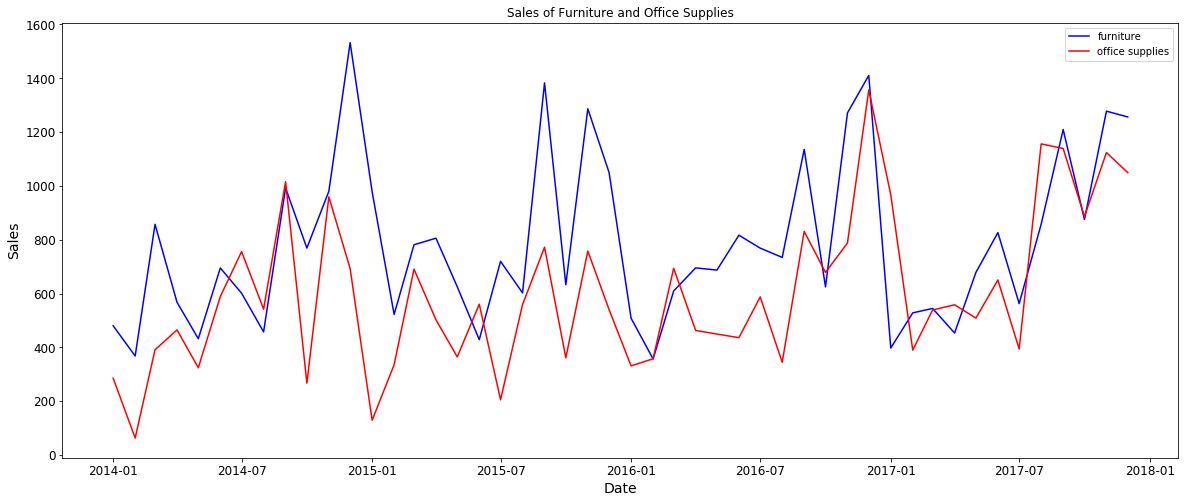

In [23]:
plt.figure(figsize=(20, 8))
plt.plot(sold['Order Date'], sold['Sales_x'], 'b-', label = 'furniture')
plt.plot(sold['Order Date'], sold['Sales_y'], 'r-', label = 'office supplies')
plt.xlabel('Date')
plt.ylabel('Sales') 
plt.title('Sales of Furniture and Office Supplies')
plt.legend()

### FBProphet

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


<Figure size 1296x432 with 0 Axes>

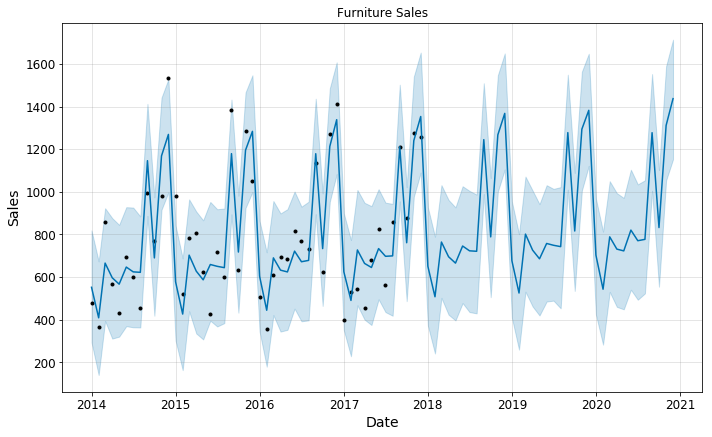

In [25]:
furniture = furniture.rename(columns={'Order Date': 'ds', 'Sales': 'y'})
furniture_model = Prophet(interval_width=0.95)
furniture_model.fit(furniture)

office = office.rename(columns={'Order Date': 'ds', 'Sales': 'y'})
office_model = Prophet(interval_width=0.95)
office_model.fit(office)

furniture_forecast = furniture_model.make_future_dataframe(periods=36, freq='MS')
furniture_forecast = furniture_model.predict(furniture_forecast)

office_forecast = office_model.make_future_dataframe(periods=36, freq='MS')
office_forecast = office_model.predict(office_forecast)

plt.figure(figsize=(18, 6))
furniture_model.plot(furniture_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Furniture Sales');